<a href="https://colab.research.google.com/github/jaredlan1/getting_started_with_ML/blob/main/HW_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.stats import qmc

np.random.seed(0)
torch.manual_seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


In [75]:
debug = 1

In [76]:
nu = 0.01 / np.pi # viscosity
N_u = 100 # num of labeld points, Intial and Boundary
N_f = 10000 # numb of collocation points

# initial conditions : u(0,x) = -sin(pi*x)

N_ic = 50 # step size for x_ic
x_ic = np.linspace(-1,1, N_ic)[:, None] #[] transform to 2d column vector
if debug == 1 :print(f"x_ic : {x_ic}")
t_ic = np.zeros_like(x_ic)
u_ic = -np.sin(np.pi * x_ic)
if debug ==1 :print(f'u_ic : {u_ic}')

#BC
N_bc = N_u - N_ic
t_bc = np.random.rand(N_bc, 1)
x_bc = np.vstack([
        -np.ones((N_bc//2,1)),
        np.ones((N_bc - N_bc // 2,1))
])
t_bc=np.vstack([t_bc[:N_bc // 2], t_bc[N_bc // 2:]])
u_bc = np.zeros_like(x_bc)

if debug ==1: print(f"x_bc : {x_bc}")

x_u = np.vstack([x_ic, x_bc])
t_u = np.vstack([t_ic, t_bc])
u_u = np.vstack([u_ic, u_bc])

if debug ==1: print(f"shape of x_u: {x_u.shape}") #(100,1)

#setting collocation poitns using the latinhypercube
sampler= qmc.LatinHypercube(d=2, seed=0)
X_f = sampler.random(n=N_f)
x_f = 2.0 * X_f[:, [0]] - 1.0 #scale to [-1,1]
t_f = X_f[:, [1]] #[0,1]

def to_tensor(a, requires_grad=False, dtype=torch.float32):
    return torch.tensor(a, dtype=dtype, device=device, requires_grad=requires_grad)

x_u_t = to_tensor(x_u, requires_grad=True)
t_u_t = to_tensor(t_u, requires_grad=True)
u_u_t = to_tensor(u_u, requires_grad=False)

x_f_all = to_tensor(x_f, requires_grad=False)
t_f_all = to_tensor(t_f, requires_grad=False)

if debug ==1 :print("x_u_t:", x_u_t.shape, "t_u_t:", t_u_t.shape, "u_u_t:", u_u_t.shape)
if debug ==1 :print("x_f_all:", x_f_all.shape, "t_f_all:", t_f_all.shape)


x_ic : [[-1.        ]
 [-0.95918367]
 [-0.91836735]
 [-0.87755102]
 [-0.83673469]
 [-0.79591837]
 [-0.75510204]
 [-0.71428571]
 [-0.67346939]
 [-0.63265306]
 [-0.59183673]
 [-0.55102041]
 [-0.51020408]
 [-0.46938776]
 [-0.42857143]
 [-0.3877551 ]
 [-0.34693878]
 [-0.30612245]
 [-0.26530612]
 [-0.2244898 ]
 [-0.18367347]
 [-0.14285714]
 [-0.10204082]
 [-0.06122449]
 [-0.02040816]
 [ 0.02040816]
 [ 0.06122449]
 [ 0.10204082]
 [ 0.14285714]
 [ 0.18367347]
 [ 0.2244898 ]
 [ 0.26530612]
 [ 0.30612245]
 [ 0.34693878]
 [ 0.3877551 ]
 [ 0.42857143]
 [ 0.46938776]
 [ 0.51020408]
 [ 0.55102041]
 [ 0.59183673]
 [ 0.63265306]
 [ 0.67346939]
 [ 0.71428571]
 [ 0.75510204]
 [ 0.79591837]
 [ 0.83673469]
 [ 0.87755102]
 [ 0.91836735]
 [ 0.95918367]
 [ 1.        ]]
u_ic : [[ 1.22464680e-16]
 [ 1.27877162e-01]
 [ 2.53654584e-01]
 [ 3.75267005e-01]
 [ 4.90717552e-01]
 [ 5.98110530e-01]
 [ 6.95682551e-01]
 [ 7.81831482e-01]
 [ 8.55142763e-01]
 [ 9.14412623e-01]
 [ 9.58667853e-01]
 [ 9.87181783e-01]
 [ 9.99

In [77]:
class PINN( torch.nn.Module):
  def __init__(self, layers):
    super().__init__()
    self.layers = torch.nn.ModuleList()
    for i in range(len(layers)-1):
      self.layers.append(torch.nn.Linear(layers[i], layers[i+1]))

    for m in self.layers:
        torch.nn.init.xavier_normal_(m.weight)
        torch.nn.init.zeros_(m.bias)

  def forward(self, x,t):
    z=torch.cat([x,t], dim=1)
    for i, layer in enumerate(self.layers):
      z=layer(z)
      if i < len(self.layers)-1:
          z=torch.tanh(z)
    return z

model = PINN([2,64,64,64,64,1]).to(device)
if debug ==1:print(model)

PINN(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1-3): 3 x Linear(in_features=64, out_features=64, bias=True)
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [78]:
def burgers_residual(x,t):

  u=model(x,t)
  ones=torch.ones_like(u)

  u_t = torch.autograd.grad(u,t,grad_outputs=ones, create_graph=True, retain_graph=True)[0]

  u_x=torch.autograd.grad(u,x,grad_outputs=ones, create_graph=True, retain_graph=True)[0]

  u_xx=torch.autograd.grad(u_x,x,grad_outputs=torch.ones_like(u_x), create_graph=True, retain_graph=True)[0]
  f= u_t + u*u_x- nu*u_xx
  return f


In [79]:
loss_hist   = []
loss_u_hist = []
loss_f_hist = []

In [80]:
lr = 1e-3
epochs = 5000
batch_f = 2000
optimizer= torch.optim.Adam(model.parameters(),lr=lr)

for ep in range(1, epochs +1):
  optimizer.zero_grad(set_to_none=True)

  u_pred = model(x_u_t, t_u_t)
  loss_u = torch.mean((u_pred-u_u_t)**2)

  idx=torch.randint(0,N_f,(batch_f,),device=device)
  x_f_b=x_f_all[idx].clone().detach().requires_grad_(True)
  t_f_b= t_f_all[idx].clone().detach().requires_grad_(True)

  f_pred= burgers_residual(x_f_b, t_f_b)
  loss_f=torch.mean(f_pred**2)

  loss = loss_u+loss_f
  loss.backward()
  optimizer.step()

  loss_hist.append(loss.item())
  loss_u_hist.append(loss_u.item())
  loss_f_hist.append(loss_f.item())


  if ep % 500 == 0 or ep == 1:
        print(f"epoch {ep:5d} | loss {loss.item():.3e} | loss_u {loss_u.item():.3e} | loss_f {loss_f.item():.3e}")


epoch     1 | loss 3.880e-01 | loss_u 3.301e-01 | loss_f 5.786e-02
epoch   500 | loss 6.461e-02 | loss_u 4.842e-02 | loss_f 1.619e-02
epoch  1000 | loss 5.084e-02 | loss_u 3.710e-02 | loss_f 1.373e-02
epoch  1500 | loss 4.948e-02 | loss_u 3.790e-02 | loss_f 1.158e-02
epoch  2000 | loss 4.465e-02 | loss_u 3.244e-02 | loss_f 1.222e-02
epoch  2500 | loss 3.499e-02 | loss_u 2.273e-02 | loss_f 1.226e-02
epoch  3000 | loss 2.030e-02 | loss_u 1.316e-02 | loss_f 7.143e-03
epoch  3500 | loss 1.642e-02 | loss_u 1.302e-02 | loss_f 3.396e-03
epoch  4000 | loss 1.039e-02 | loss_u 6.900e-03 | loss_f 3.492e-03
epoch  4500 | loss 9.988e-03 | loss_u 6.746e-03 | loss_f 3.243e-03
epoch  5000 | loss 5.303e-03 | loss_u 3.449e-03 | loss_f 1.854e-03


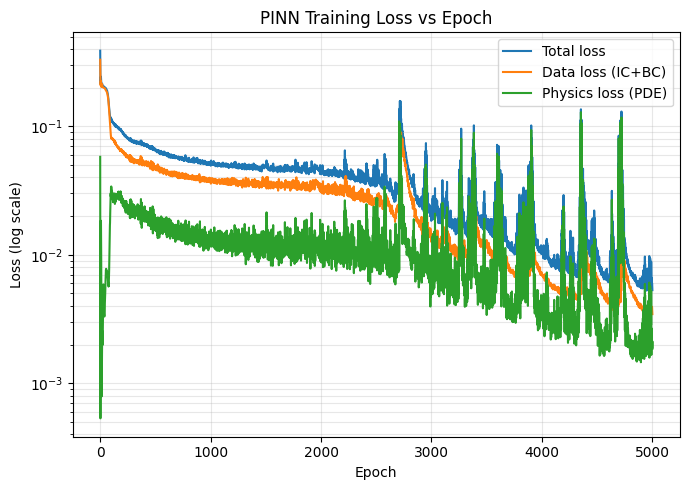

In [81]:

epochs_arr = np.arange(1, epochs + 1)

plt.figure(figsize=(7,5))
plt.semilogy(epochs_arr, loss_hist,   label="Total loss")
plt.semilogy(epochs_arr, loss_u_hist, label="Data loss (IC+BC)")
plt.semilogy(epochs_arr, loss_f_hist, label="Physics loss (PDE)")

plt.xlabel("Epoch")
plt.ylabel("Loss (log scale)")
plt.title("PINN Training Loss vs Epoch")
plt.legend()
plt.grid(True, which="both", alpha=0.3)
plt.tight_layout()
plt.show()

In [82]:
model.eval()

nx, nt = 256, 101
xg= np.linspace(-1,1,nx)
tg=np.linspace(0,1,nt)

T,X = np.meshgrid(tg,xg) #(nx,nt)

with torch.no_grad():
  X_t = to_tensor(X.reshape(-1,1), requires_grad=False)
  T_t=to_tensor(T.reshape(-1,1), requires_grad=False)
  U_pred=model(X_t,T_t).detach().cpu().numpy().reshape(nx,nt)

  t_slice = .75
with torch.no_grad():
  x_slice_t=to_tensor(xg[:,None],requires_grad=False)
  t_slice_t=to_tensor((t_slice*np.ones((nx,1))),requires_grad=False)
  u_slice_pred = model(x_slice_t, t_slice_t).detach().cpu().numpy().ravel()

print("U_pred:", U_pred.shape, "u_slice_pred:", u_slice_pred.shape)


U_pred: (256, 101) u_slice_pred: (256,)


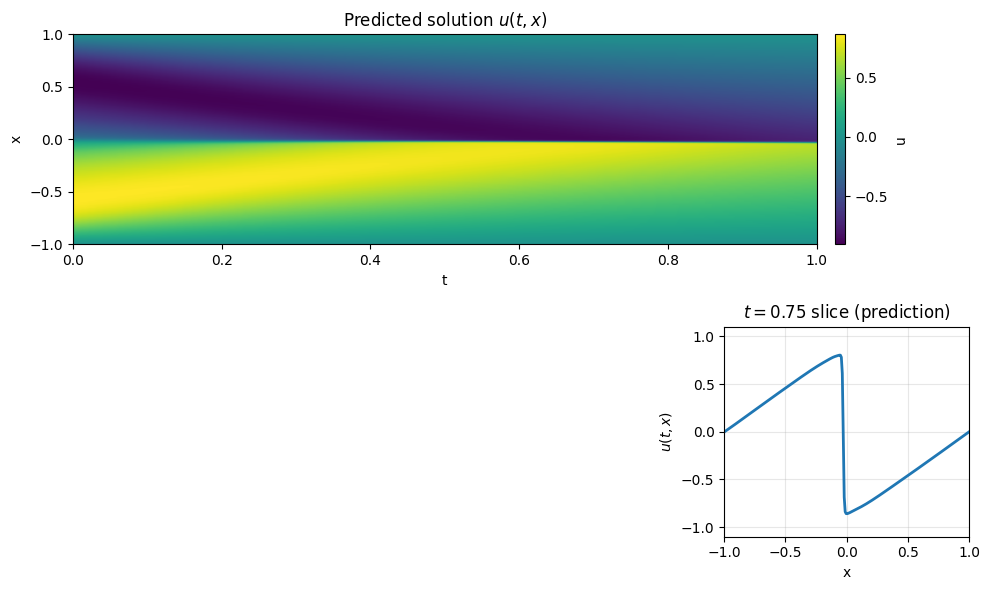

In [83]:
fig=plt.figure(figsize=(10, 6))

ax1=plt.subplot2grid((2, 3), (0, 0), colspan=3)
im = ax1.imshow(
    U_pred,
    aspect="auto",
    origin="lower",
    extent=[tg.min(), tg.max(), xg.min(), xg.max()],
)
ax1.set_xlabel("t")
ax1.set_ylabel("x")
ax1.set_title("Predicted solution $u(t,x)$")
cbar = plt.colorbar(im, ax=ax1, pad=0.02)
cbar.set_label("u")

# Bottom-right: slice at t=0.75 (prediction only)
ax2 = plt.subplot2grid((2, 3), (1, 2))
ax2.plot(xg, u_slice_pred, linewidth=2)
ax2.set_title(r"$t=0.75$ slice (prediction)")
ax2.set_xlabel("x")
ax2.set_ylabel(r"$u(t,x)$")
ax2.set_xlim([-1, 1])
ax2.set_ylim([-1.1, 1.1])
ax2.grid(True, alpha=0.3)

# blank panels to mimic "rightmost only"
plt.subplot2grid((2, 3), (1, 0)).axis("off")
plt.subplot2grid((2, 3), (1, 1)).axis("off")

plt.tight_layout()
plt.show()

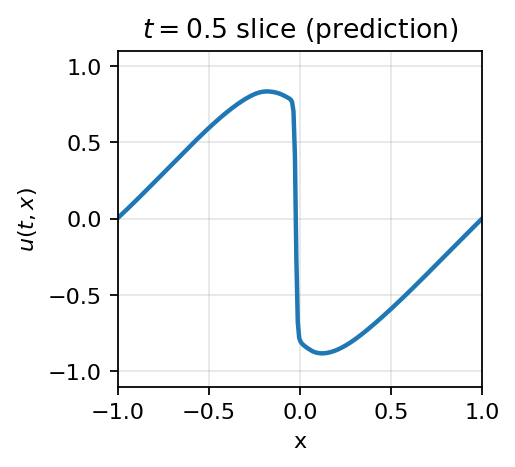

In [84]:
t_slice = .5
with torch.no_grad():
    x_slice_t=to_tensor(xg[:,None],requires_grad=False)
    t_slice_t=to_tensor((t_slice*np.ones((nx,1))),requires_grad=False)
    u_slice_pred = model(x_slice_t, t_slice_t).detach().cpu().numpy().ravel()

fig=plt.figure(figsize=(10, 6),dpi=160)
ax2 = plt.subplot2grid((2, 3), (1, 2))
ax2.plot(xg, u_slice_pred, linewidth=2)
ax2.set_title(r"$t=0.5$ slice (prediction)")
ax2.set_xlabel("x")
ax2.set_ylabel(r"$u(t,x)$")
ax2.set_xlim([-1, 1])
ax2.set_ylim([-1.1, 1.1])
ax2.grid(True, alpha=0.3)


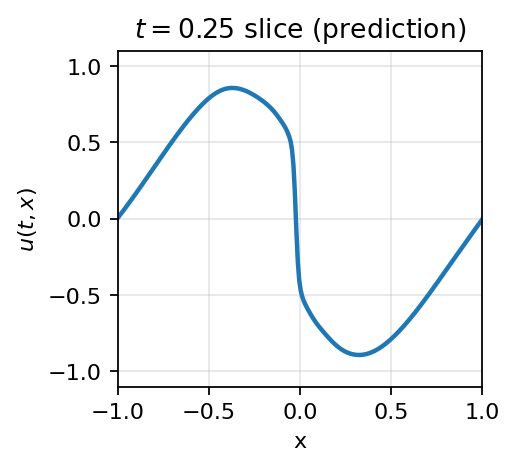

In [85]:
t_slice = .25
with torch.no_grad():
    x_slice_t=to_tensor(xg[:,None],requires_grad=False)
    t_slice_t=to_tensor((t_slice*np.ones((nx,1))),requires_grad=False)
    u_slice_pred = model(x_slice_t, t_slice_t).detach().cpu().numpy().ravel()

fig=plt.figure(figsize=(10, 6),dpi=160)
ax2 = plt.subplot2grid((2, 3), (1, 2))
ax2.plot(xg, u_slice_pred, linewidth=2)
ax2.set_title(r"$t=0.25$ slice (prediction)")
ax2.set_xlabel("x")
ax2.set_ylabel(r"$u(t,x)$")
ax2.set_xlim([-1, 1])
ax2.set_ylim([-1.1, 1.1])
ax2.grid(True, alpha=0.3)

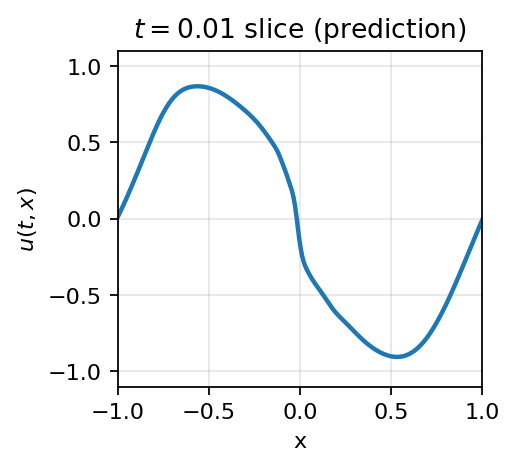

In [86]:
t_slice = .01
with torch.no_grad():
    x_slice_t=to_tensor(xg[:,None],requires_grad=False)
    t_slice_t=to_tensor((t_slice*np.ones((nx,1))),requires_grad=False)
    u_slice_pred = model(x_slice_t, t_slice_t).detach().cpu().numpy().ravel()

fig=plt.figure(figsize=(10, 6),dpi=160)
ax2 = plt.subplot2grid((2, 3), (1, 2))
ax2.plot(xg, u_slice_pred, linewidth=2)
ax2.set_title(r"$t=0.01$ slice (prediction)")
ax2.set_xlabel("x")
ax2.set_ylabel(r"$u(t,x)$")
ax2.set_xlim([-1, 1])
ax2.set_ylim([-1.1, 1.1])
ax2.grid(True, alpha=0.3)